#### Importing Libraries to be used

In [411]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from prettytable import PrettyTable
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
import pickle
import os
from flask import Flask,render_template,request,flash
from warnings import filterwarnings
filterwarnings('ignore')

#### Task1 : We need to predict the medical charges for an insurance company using Linear regression. A dataset called insurance is provided

###### Importing the dataset

In [412]:
data= pd.read_csv("insurance.csv")

###### Checking missing values

In [413]:
data.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

##### 1.1 The summary statistics of the variable charges


In [414]:
data['charges'].describe()

count     1338.000000
mean     13270.422265
std      12110.011237
min       1121.873900
25%       4740.287150
50%       9382.033000
75%      16639.912515
max      63770.428010
Name: charges, dtype: float64

In [415]:
columns = ["Oobs", "Mean", "Std", "Min", "25%", "50%", "75%", "Max"]

table1 = PrettyTable(columns)
table1.add_row([data['charges'].describe()[0],data['charges'].describe()[1],data['charges'].describe()[2],data['charges'].describe()[3],data['charges'].describe()[4],data['charges'].describe()[5],data['charges'].describe()[6],data['charges'].describe()[7]])
print(table1)

+--------+--------------------+--------------------+-----------+------------+----------+--------------+-------------+
|  Oobs  |        Mean        |        Std         |    Min    |    25%     |   50%    |     75%      |     Max     |
+--------+--------------------+--------------------+-----------+------------+----------+--------------+-------------+
| 1338.0 | 13270.422265141257 | 12110.011236694001 | 1121.8739 | 4740.28715 | 9382.033 | 16639.912515 | 63770.42801 |
+--------+--------------------+--------------------+-----------+------------+----------+--------------+-------------+


##### 1.2 A table that contains the number of people in each region

In [416]:
data.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

In [417]:
data['region'].value_counts()

region
southeast    364
southwest    325
northwest    325
northeast    324
Name: count, dtype: int64

In [418]:
region_counts = data['region'].value_counts()
region_percentages = (data['region'].value_counts(normalize=True) * 100).round(2)
region_table = PrettyTable(['Region', 'Counts', 'Percentage'])
for region, count, percentage in zip(region_counts.index, region_counts.values, region_percentages.values):
    region_table.add_row([region, count, f"{percentage}%"])

print(region_table)

+-----------+--------+------------+
|   Region  | Counts | Percentage |
+-----------+--------+------------+
| southeast |  364   |   27.2%    |
| southwest |  325   |   24.29%   |
| northwest |  325   |   24.29%   |
| northeast |  324   |   24.22%   |
+-----------+--------+------------+


##### 1.3 The relationship among all features 

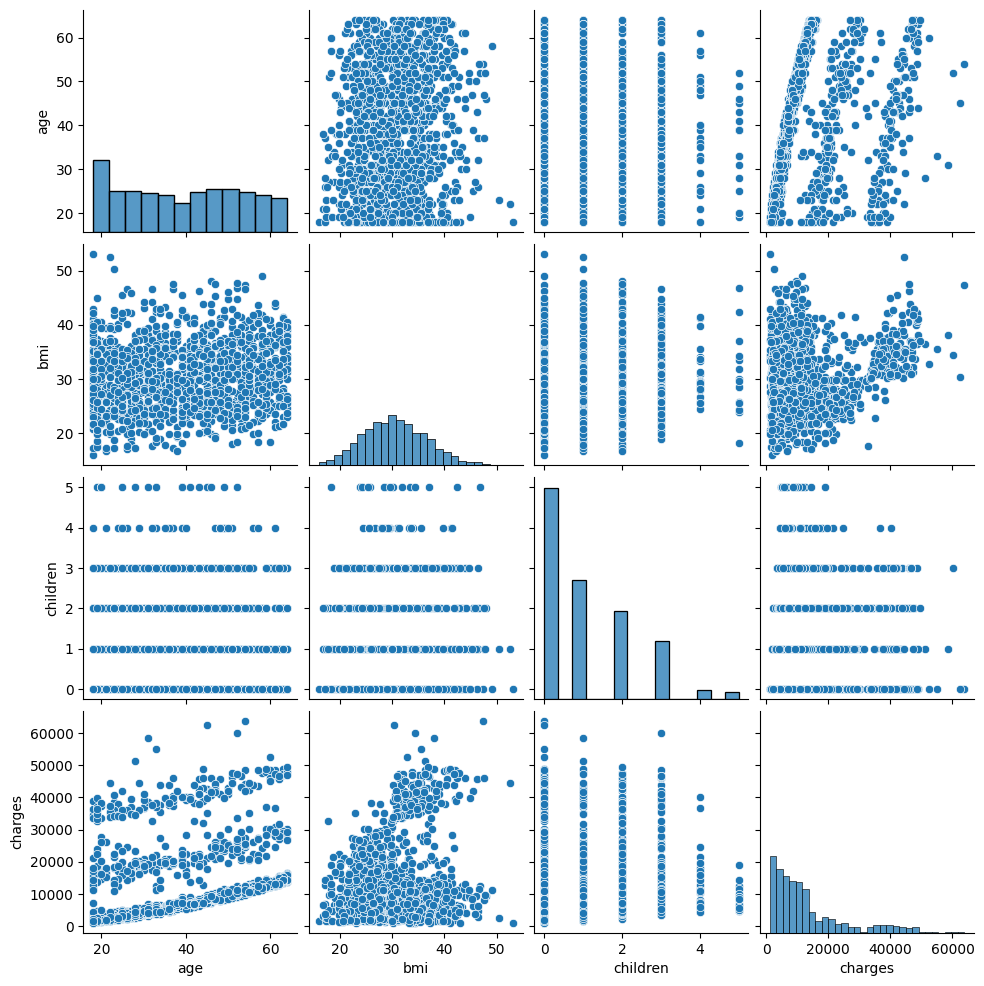

In [419]:
sns.pairplot(data, diag_kind='hist');

In [420]:
def plot_subplots(dataframe, main_title, column1, column2, column3, category,color):
    plt.figure(figsize=(20, 7))
    plt.suptitle(main_title, fontsize=20)
    
    # Scatter plot of column1 vs column2 with category as hue
    sns.scatterplot(data=dataframe, x=column1, y=column2, hue=category, ax=plt.subplot(1, 3, 1),palette=color)
    plt.title(f"{column1.capitalize()} Vs {column2.capitalize()}")
    plt.xlabel(f"{column1.capitalize()}")
    plt.ylabel(f"{column2.capitalize()}")
    
    # Scatter plot of column1 vs column3 with category as hue
    sns.scatterplot(data=dataframe, x=column1, y=column3, hue=category, ax=plt.subplot(1, 3, 2),palette=color)
    plt.title(f"{column1.capitalize()} Vs {column3.capitalize()}")
    plt.xlabel(f"{column1.capitalize()}")
    plt.ylabel(f"{column3.capitalize()}")
    
    # Scatter plot of column2 vs column3 with category as hue
    sns.scatterplot(data=dataframe, x=column2, y=column3, hue=category, ax=plt.subplot(1, 3, 3),palette=color)
    plt.title(f"{column2.capitalize()} Vs {column3.capitalize()}")
    plt.xlabel(f"{column2.capitalize()}")
    plt.ylabel(f"{column3.capitalize()}")
    
    plt.legend()
    plt.show()


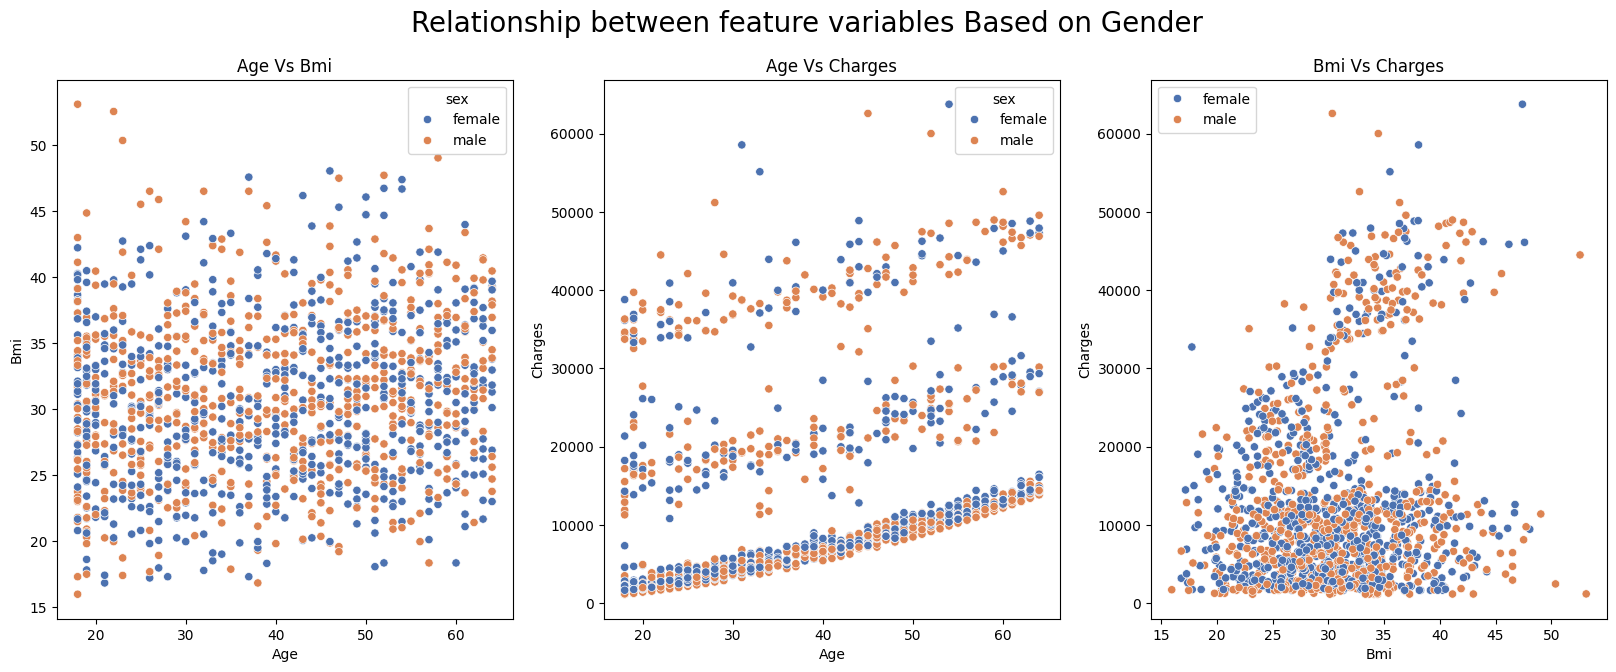

In [421]:
plot_subplots(dataframe=data, main_title="Relationship between feature variables Based on Gender", column1="age", column2="bmi", column3='charges', category='sex',color='deep')

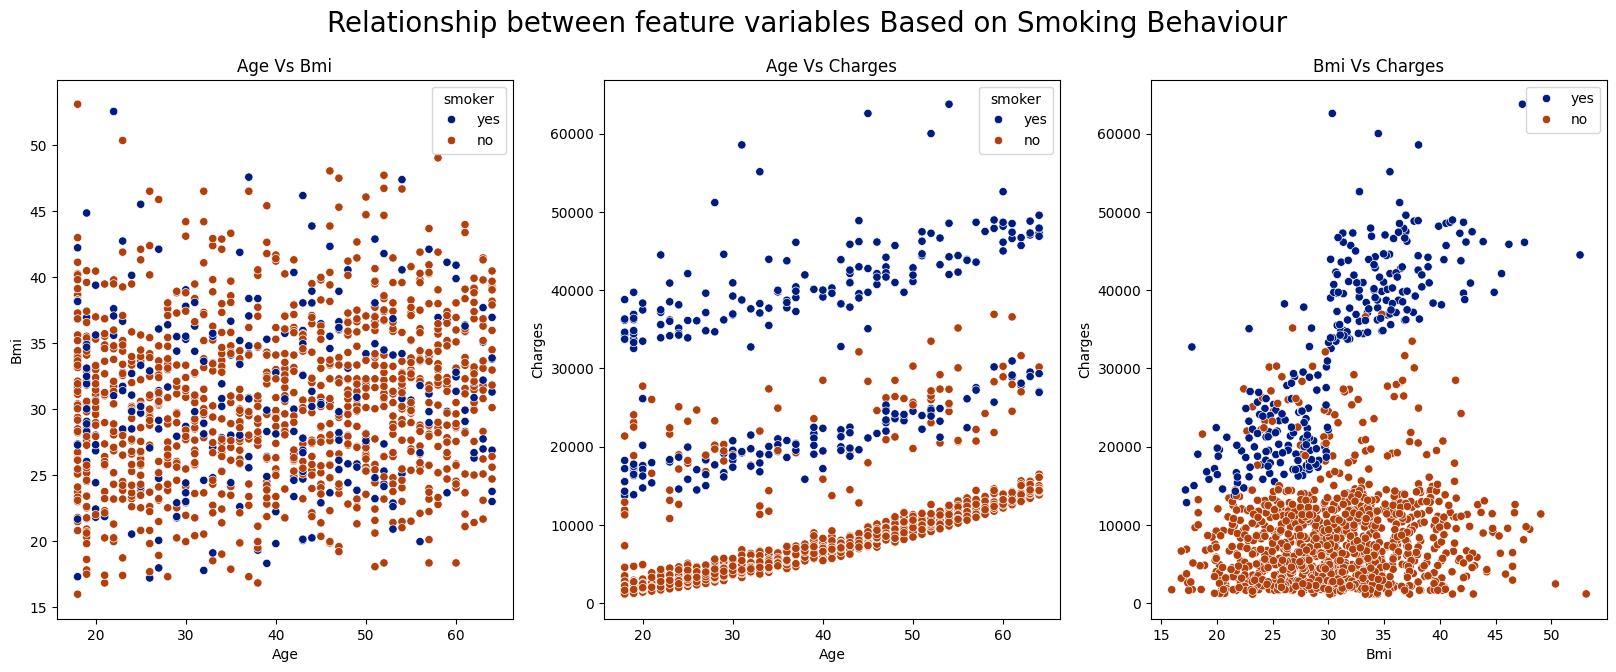

In [422]:
plot_subplots(dataframe=data, main_title="Relationship between feature variables Based on Smoking Behaviour", column1="age", column2="bmi", column3='charges', category='smoker',color='dark')

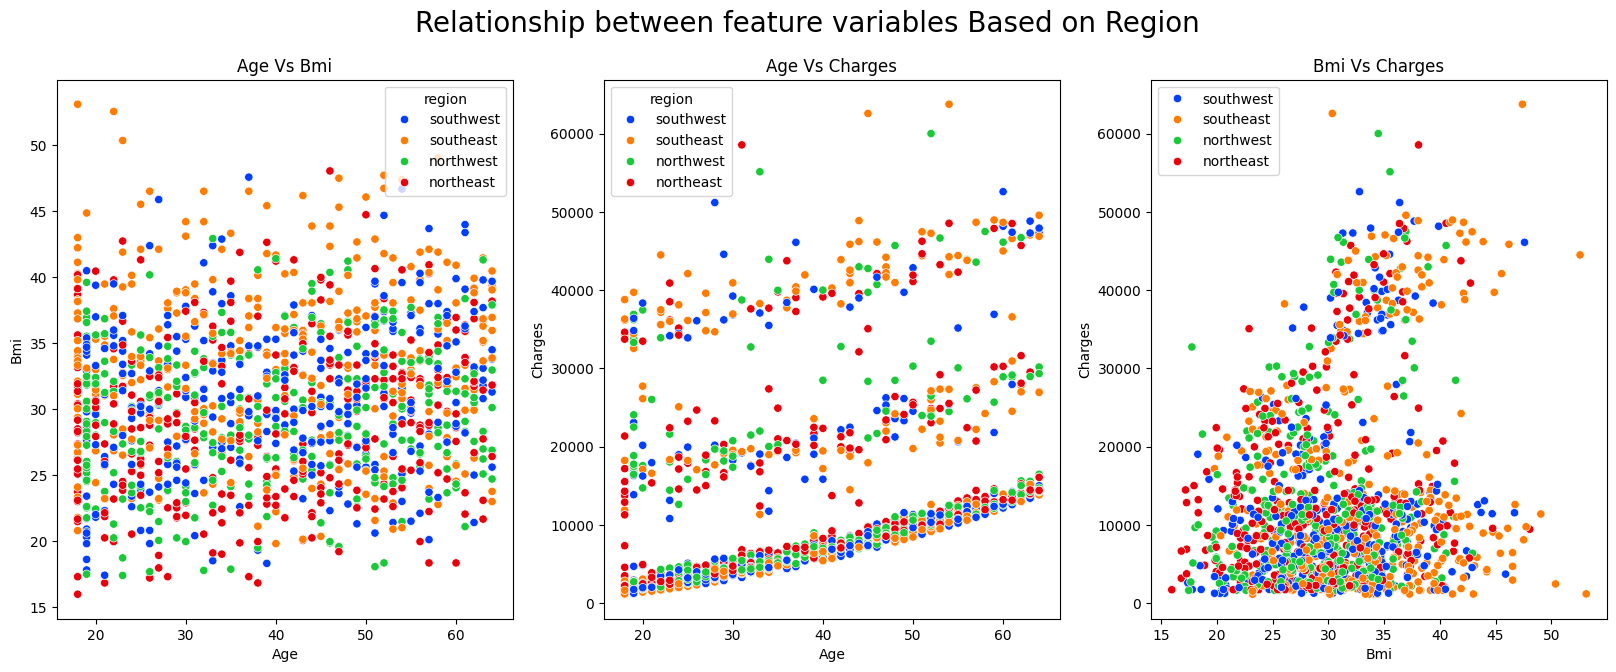

In [423]:
plot_subplots(dataframe=data, main_title="Relationship between feature variables Based on Region", column1="age", column2="bmi", column3='charges', category='region',color='bright')

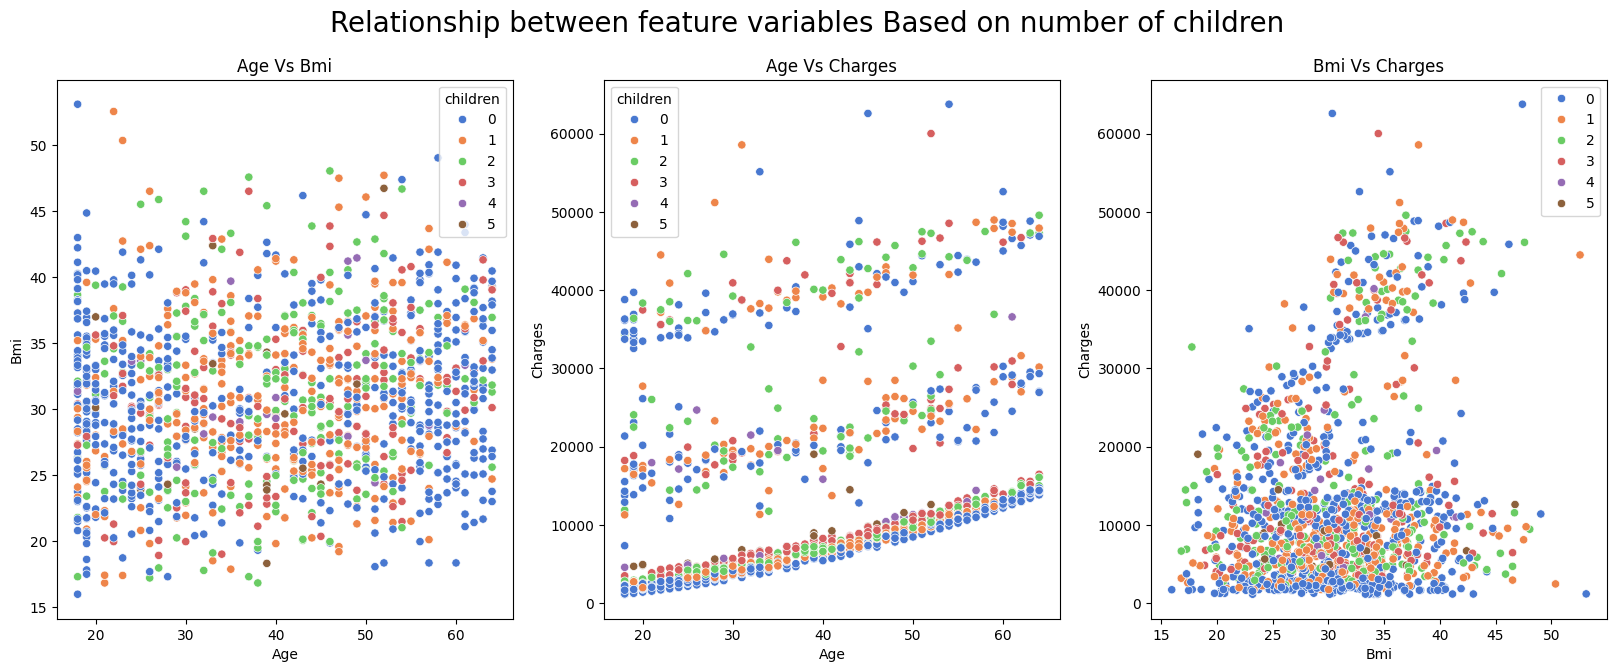

In [424]:
plot_subplots(dataframe=data, main_title="Relationship between feature variables Based on number of children", column1="age", column2="bmi", column3='charges', category='children',color='muted')

##### 1.4 Train a model on the data

In [425]:
data['sex_encoded'] = data['sex'].map({'male': 0, 'female': 1})
data['smoker_encoded'] = data['smoker'].map({'no': 0, 'yes': 1})
data['region_encoded'] = data['region'].map({'southeast': 0, 'southwest': 1,'northwest': 2, 'northeast': 3})

In [426]:
X = data[['age', 'sex_encoded', 'bmi', 'children', 'smoker_encoded', 'region_encoded']]
y=data['charges']

In [427]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
predictions = model.predict(X_test)

#### 1.5 Evaluate the model performance

In [428]:
r_squared = r2_score(y_test, predictions)
print("The R-squarred of our model is:",round(r_squared,4))

The R-squarred of our model is: 0.7839


####  1.6 Improve the model performance

##### Feature selection using Stepwise forward regression

In [429]:
def forward_regression(feature_var, y, threshold_in, verbose=False):
    # Creation of an empty list to hold the selected features
    initial_list = []
    included = list(initial_list)
    
    # I made an infinite loop.
    while True:
        changed = False    # I set up a flag to track changes.
        excluded = list(set(feature_var.columns) - set(included))   # Get a list of all the features that have not been selected
        new_pval = pd.Series(index=excluded)
        
        for new_column in excluded:    # loop over the features that were not chosen.
            # Combine the included features and the new feature in an OLS model.
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(feature_var[included + [new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        
        best_pval = new_pval.min()
        
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed = True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))
                
            # Print the p-value of the best predictor variable
            print('P-value of {}: {:.6}'.format(best_feature, best_pval))

        if not changed:
            break

    return included

In [430]:
selected_var=forward_regression(X, y,0.05,verbose=False)
print("The Selected Variables are:")
selected_var

P-value of smoker_encoded: 8.27144e-283
P-value of age: 2.90975e-92
P-value of bmi: 2.41856e-30
P-value of children: 0.000607716
P-value of region_encoded: 0.0152306
The Selected Variables are:


['smoker_encoded', 'age', 'bmi', 'children', 'region_encoded']

In [431]:
X1 = data[['smoker_encoded', 'age', 'bmi', 'children', 'region_encoded']]
y1= data['charges']

In [432]:
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.2, random_state=42)
model1 = LinearRegression()
model1.fit(X_train, y_train)
pred = model1.predict(X_test)

In [433]:
r1_squared = r2_score(y_test, pred)
print("The R-squarred of our model after feature selection is:",round(r1_squared,2))

The R-squarred of our model after feature selection is: 0.78


#### Model Performance By considering Age Only

In [434]:
X2 = data[['age']]
y2= data['charges']

In [435]:
X_train, X_test, y_train, y_test = train_test_split(X2, y2,test_size=0.2, random_state=42)
model2 = LinearRegression()
model2.fit(X_train, y_train)
pred_with_age = model2.predict(X_test)

In [436]:
r2_squared = r2_score(y_test, pred_with_age)
print("The R-squarred of our model using only age as input is:",round(r2_squared,4))

The R-squarred of our model using only age as input is: 0.1241


#### Model Performance By considering both Smoking and BMI

In [437]:
X3 = data[['smoker_encoded','bmi']]
y3= data['charges']

In [438]:
X_train, X_test, y_train, y_test = train_test_split(X3, y3,test_size=0.2, random_state=42)
model3 = LinearRegression()
model3.fit(X_train, y_train)
pred_with_smoke_bmi = model3.predict(X_test)

In [439]:
r2_squared = r2_score(y_test, pred_with_smoke_bmi)
print("The R-squarred of our model using both smoking behaviour and BMI as input is:",round(r2_squared,2))

The R-squarred of our model using both smoking behaviour and BMI as input is: 0.69


##### Model Performance by considering Both Smoking and Obesity

In [440]:
data.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges',
       'sex_encoded', 'smoker_encoded', 'region_encoded'],
      dtype='object')

Creatimg a new column that indicate whether a person has smokes and has obesity or not

In [441]:
new_column_values = []
for index, row in data.iterrows():
    if row['smoker'] == "yes" and row['bmi'] > 30:
        new_column_values.append(1)
    else:
        new_column_values.append(0)

data['smoker & Obesity'] = new_column_values

In [442]:
X4 = data[['age', 'bmi', 'children', 'smoker_encoded', 'region_encoded', 'smoker & Obesity']]
y4 = data['charges']

In [443]:
X_train, X_test, y_train, y_test = train_test_split(X4, y4,test_size=0.2, random_state=42)
model4 = LinearRegression()
model4.fit(X_train, y_train)
prediction_with_smoke_obese = model4.predict(X_test)

In [444]:
r4_squared = r2_score(y_test, prediction_with_smoke_obese)
print("The R-squarred of our model using both smoking behaviour and BMI as input is:",round(r4_squared,2))

The R-squarred of our model using both smoking behaviour and BMI as input is: 0.88


In [445]:
forward_regression(X4, y4,0.05,verbose=False)

P-value of smoker & Obesity: 1.99029e-319
P-value of smoker_encoded: 1.9701e-103
P-value of age: 4.73533e-155
P-value of children: 8.90186e-07
P-value of region_encoded: 0.0271169
P-value of bmi: 0.00546829


['smoker & Obesity',
 'smoker_encoded',
 'age',
 'children',
 'region_encoded',
 'bmi']

#### Model Deployment

In [446]:
directory = 'saved-models'
# Create the directory if it doesn't exist
if not os.path.exists(directory):
    os.makedirs(directory)

# Save the model to the specified file
with open(os.path.join(directory, 'model4.pkl'), 'wb') as model_file:
    pickle.dump(model4, model_file)

In [447]:
pickle.dump(model4, open('saved-models/model4.pkl','wb')) #This is the model we will load on the server

In [448]:
model = pickle.load(open('saved-models/model4.pkl','rb'))
print(model.predict([[12,1,30,4,0,2]]))

[105347.0528193]


In [449]:
app=Flask(__name__) #creates the app to process the user input
#Configure the app
app.logger.setLevel('INFO')
app.secret_key = "project"

#Define the functions that represent the actions that occur as the user interacts with the app.
@app.route('/')
def home():
    return render_template('index.html')

@app.route('/predict', methods=['GET', 'POST'])  # Correct the route to match the form action
def predict():
    prediction = None  # Define default values for prediction and color_signal
    color_signal = None

    if request.method == 'POST':
        try:
            # Retrieve the form inputs
            AGE = float(request.form['AGE'])
            BMI = float(request.form['BMI'])
            Children = float(request.form['Children'])
            SMOKER = float(request.form['SMOKER'])
            Region = float(request.form['Region'])
            Obesity = float(request.form['Obesity'])

            # Consolidate the inputs
            input_args = [AGE, BMI, Children, SMOKER, Region, Obesity]
            input_arr = np.array(input_args)
            inputs = input_arr.reshape(1, -1)

            # Load the saved model
            model = pickle.load(open('saved-models/model4.pkl', 'rb'))
            result = model.predict(inputs)

            if int(result) != 1:
                prediction = result
                color_signal = 'purple'
            elif int(result) == 0:
                prediction = result
                color_signal = 'green'

            # Populate flashed messages
            flash(prediction)
            flash(color_signal)

        except ValueError:
            return "Error: Values not valid."
    return render_template('predict.html', prediction=prediction, color_signal=color_signal)


In [450]:
if __name__=='__main__':
    app.run(host='localhost', port=1898, debug=False)

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://localhost:1898
Press CTRL+C to quit
127.0.0.1 - - [27/Apr/2024 11:54:06] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [27/Apr/2024 11:54:06] "GET /static/logo.png HTTP/1.1" 304 -
127.0.0.1 - - [27/Apr/2024 11:54:07] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [27/Apr/2024 11:54:25] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [27/Apr/2024 11:54:25] "GET /static/logo.png HTTP/1.1" 304 -
